In [1]:
import numpy as np
import pandas as pd
import matplotlib
from cycler import cycler

# Define custom colors in matplotlib for our plots. The color palette
# is manually tuned from one generated on coolors.co
colors_map = matplotlib.colors.get_named_colors_mapping()
colors_map.cache.clear()
colors_map.update({
    "custom:primary": "#262626",
    "custom:secondary": "#dfac29",
    "custom:highlight": colors_map["tab:red"]
})

# Set some nice plotting defaults. These have been built up from the past
# two lab assignments
CUSTOM_PLOT_STYLE = {
    "text.usetex": True,

    "font.family": "serif",
    "font.size": 16,

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 1.5,
    "lines.linewidth": 1.5,
    # "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none",
    "savefig.dpi": 300,

    # Use our custom defined colors by default
    "axes.prop_cycle": cycler(color=("custom:primary", "custom:secondary",)),

    # Higher DPI for sharper inline images
    "figure.dpi": 96
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

In [2]:
# Load the time-series flux data into a dataframe just to keep track of the multiple
# arrays we often want to index together. I don't actually use pandas functions/methods
# for anything, it's just for organization (could be replaced with astropy.Table or anything similar)
df = pd.read_csv("data.dat", delimiter="\t", names=("time", "flux", "err_flux"))

In [3]:
# Remove a central pivot time from each time per directions. Store it in a new
# column so we don't overwrite anything.
pivot = df["time"].median()
df["ptime"] = df["time"] - pivot

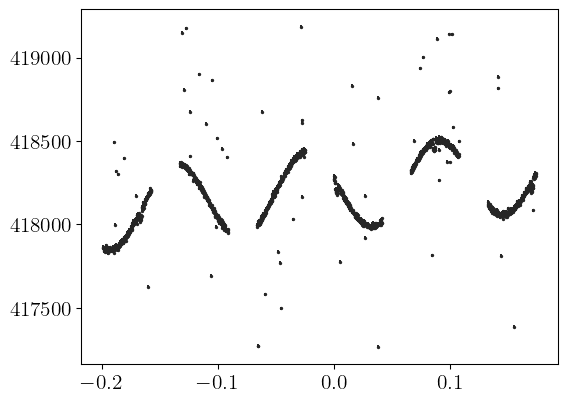

In [4]:
import matplotlib.pyplot as plt

# Quickly plot our data to see what it looks like.
fig, ax = plt.subplots()
ax.errorbar(df["ptime"], df["flux"], fmt="o", yerr=df["err_flux"])
plt.show()

In [5]:
# The data is divided into six long observation windows with gaps in between
# This line finds the beginning of each window based on the gap between
# observations.
obs_start = (0, *(1 + np.where(np.diff(df["ptime"]) > 0.01)[0]), len(df))
# and this line pairs them together into window beginning and end indices.
obs_windows = list(zip(obs_start[:-1], obs_start[1:]))
obs_windows

[(0, 268), (268, 536), (536, 802), (802, 1065), (1065, 1335), (1335, 1605)]

In [6]:
# Constants defining the transit windows from the class slides
first_transit_time = 57531.91792371155 - pivot # [days]
transit_duration = 166.484 / 24 / 3600 # [days]
transit_period = 2.025026511149096 / 24 # [days]
transit_count = 6

# Fold the times based on the information above. This will be used to make
# folded plots later. This line subtracts the correct number of periods from
# the ptime of each observation to make a new time "ftime"
df["ftime"] = df["ptime"] - first_transit_time - transit_period * ((df["ptime"] - first_transit_time + transit_period/2) // transit_period)

def find_pt(pt):
    """Gets the index of a certain ptime"""
    return np.searchsorted(df["ptime"], pt)

def find_window(pt, width):
    """Gets a window of a certain width around a central time pt"""
    return (
        np.clip(find_pt(pt-width/2), 0, len(df)),
        np.clip(find_pt(pt+width/2), 0, len(df))
    )

# Find the indices corresponding to the transits in our data.
transit_idx = []
for tn in range(transit_count):
    w = find_window(tn*transit_period+first_transit_time, transit_duration)
    # Ensure that the transit doesn't occur in an observation gap
    if w[1] - w[0] > 3:
        transit_idx.append(w)

# From the indices, make a boolean mask, so we can combine it with the outlier mask later
transit_mask = np.zeros(len(df), dtype=bool)
for ti, tf in transit_idx:
    transit_mask[ti:tf] = True

In [7]:
# Detect outliers using a rolling-median method, adding each outlier to a mask
outlier_mask = np.zeros(len(df), dtype=bool)

# iterate over each observation section
for iS, iF in obs_windows:
    # We use a five point bandwidth, so we don't evaluate the first two and last two points.
    # in each window
    for i in range(iS+2, iF-2):
        med = df["flux"][i-2:i+3].median()
        # Checks if the central point is 3 sigma above the median
        if abs(df["flux"][i] - med) / df["err_flux"][i] > 3:
            outlier_mask[i] = True

# Manually filter out outlier at the end of one window
o = obs_windows[4][1]
outlier_mask[o-2] = True

df_outlier = df[outlier_mask] # contains only the outlier points
df_transit_clean = df[transit_mask & ~outlier_mask] # contains only transit points, excluding outliers
df_clean_full = df[~outlier_mask] # excludes the outlier points, contains transits

# df_clean represents the clean background data we want to detrend
df_clean = df[~(outlier_mask | transit_mask)] # contains neither outliers nor transits

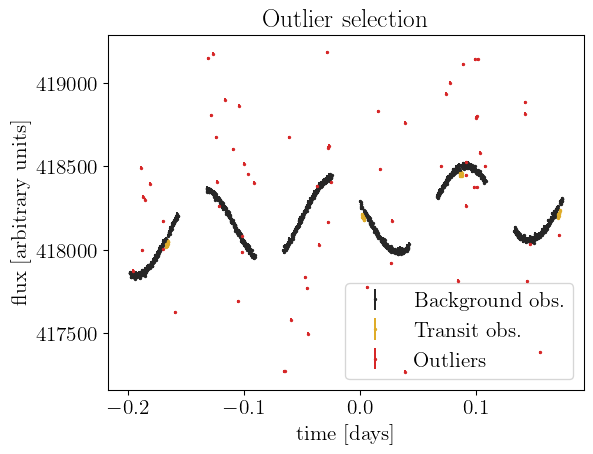

In [8]:
# Visually check that our outlier selection looks good
fig, ax = plt.subplots()

ax.errorbar(df_clean["ptime"], df_clean["flux"], fmt="o", yerr=df_clean["err_flux"], label="Background obs.")
ax.errorbar(df_transit_clean["ptime"], df_transit_clean["flux"], fmt="o", yerr=df_transit_clean["err_flux"], label="Transit obs.")
ax.errorbar(df_outlier["ptime"], df_outlier["flux"], color="custom:highlight", fmt="o", yerr=df_outlier["err_flux"], label="Outliers")

# y-axis label follows the lab slides
ax.set_ylabel("flux [arbitrary units]")
ax.set_xlabel("time [days]")
ax.set_title("Outlier selection")
ax.legend().set_zorder(-1)

plt.savefig("outliers.png")
plt.savefig("outliers.svg")

plt.show()

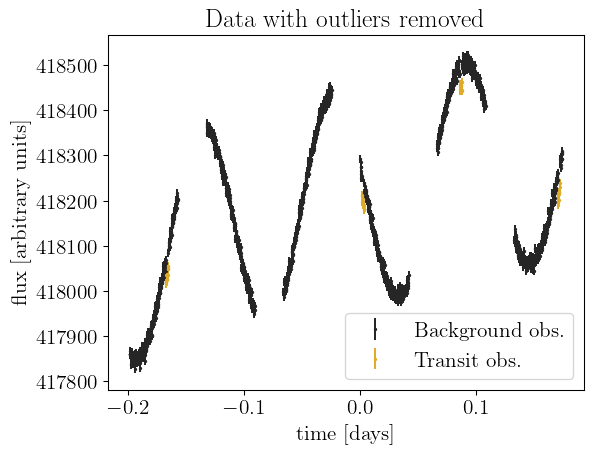

In [9]:
# Make the same plot, but without outliers
fig, ax = plt.subplots()

ax.errorbar(df_clean["ptime"], df_clean["flux"], fmt="o", yerr=df_clean["err_flux"], label="Background obs.")
ax.errorbar(df_transit_clean["ptime"], df_transit_clean["flux"], fmt="o", yerr=df_transit_clean["err_flux"], label="Transit obs.")

ax.set_ylabel("flux [arbitrary units]")
ax.set_xlabel("time [days]")
ax.set_title("Data with outliers removed")
ax.legend()

plt.savefig("post-clean.png")
plt.savefig("post-clean.svg")

plt.show()

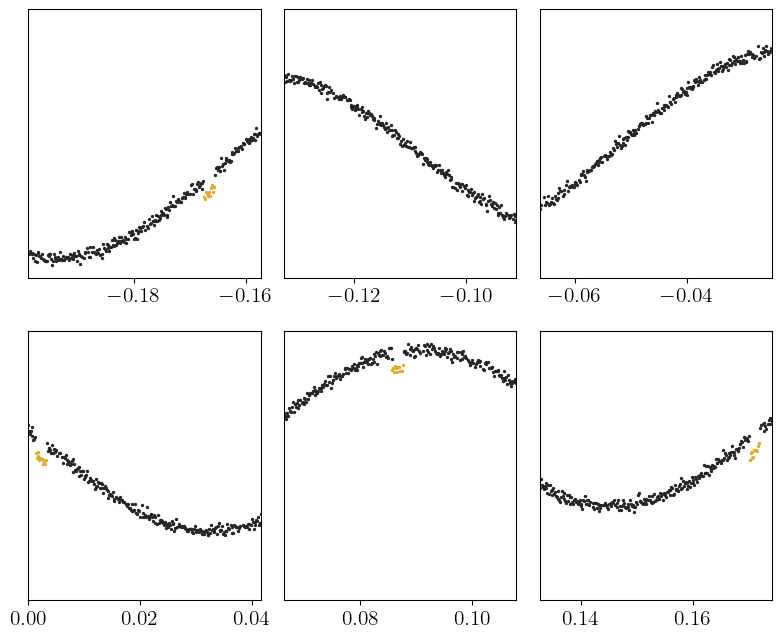

In [10]:
# Make closer up plots of each window, to visually inspect that we're not missing
# obvious outliers. This plot isn't included on the slides

# Create a grid of 6 plots, 1 for each window
fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(10, 8))
# Decreases the horizontal spacing between the the windows
fig.subplots_adjust(wspace=0.1)

for w in range(6):
    ax = axs.ravel()[w]

    # With errorbars the plots are very noisy, preventing us from seeing individual points
    # We opt for a scatter here instead
    ax.scatter(df_clean["ptime"], df_clean["flux"])
    ax.scatter(df_transit_clean["ptime"], df_transit_clean["flux"], color="custom:secondary")
    ax.set_xlim(df["ptime"][obs_windows[w][0]], df["ptime"][obs_windows[w][1]-1])
    
    ax.set_yticks([])

In [11]:
# From LEC3, a Lomb-Scargle periodogram is just a bunch of regressions with sines and cosines
# in the design matrix. Let's bake in the linear trend to not have to worry about it separately.

# The code is simplified from "TrendedLombScargle" and "LeastSquaresMixin" in gatspy
#    https://github.com/astroML/gatspy/blob/master/gatspy/periodic/

# Initial array of frequencies to test
omegas = np.linspace(10, 100, 1000)

t = np.asarray(df_clean["ptime"])
y = np.asarray(df_clean["flux"])
dy = np.asarray(df_clean["err_flux"])

yw = y / dy
chi2 = np.full_like(omegas, np.nan)

# Performs a least-squares fit by solving the normal equation (LEC3) for a
# given sinusoid frequency omega
def fit(omega):
    # Set up the design matrix X with a sin, cos, linear, and constant term
    # The sum of a sin and a cos with the same period is another sinusoid
    # with that period by harmonic addition
    Xw = np.column_stack([
        np.sin(omega * t),
        np.cos(omega * t),
        t,
        np.ones_like(t)
    ]) / dy[:, None]

    beta = np.linalg.solve(Xw.T @ Xw, Xw.T @ yw)
    chi2 = np.sum((yw - Xw @ beta)**2)

    return beta, chi2

# Given an omega and fit parameters beta, returns the modeled data on a list of times t
def model(t, omega, beta):
    return np.column_stack([
        np.sin(omega * t),
        np.cos(omega * t),
        t,
        np.ones_like(t)
    ]) @ beta

for i, omega in enumerate(omegas):
    chi2[i] = fit(omega)[1]

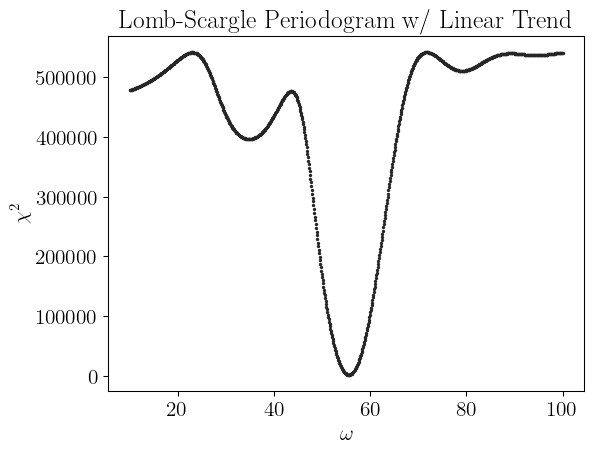

In [12]:
# Plot the initial periodogram. The resolution  here isn't great, so we will improve it in
# the next step
fig, ax = plt.subplots()
ax.scatter(omegas, chi2)
ax.set_title("Lomb-Scargle Periodogram w/ Linear Trend")
ax.set_xlabel("$\omega$")
ax.set_ylabel("$\chi^2$")
plt.savefig("periodogram.png")
plt.savefig("periodogram.svg")
plt.show()

In [13]:
# Repeat on a smaller window with better resolution around the minimum
omegas_fine = np.linspace(55, 56, 1000)
chi2_fine = np.full_like(omegas_fine, np.nan)

for i, omega in enumerate(omegas_fine):
    chi2_fine[i] = fit(omega)[1]

In [14]:
omega_best = omegas_fine[np.argmin(chi2_fine)]

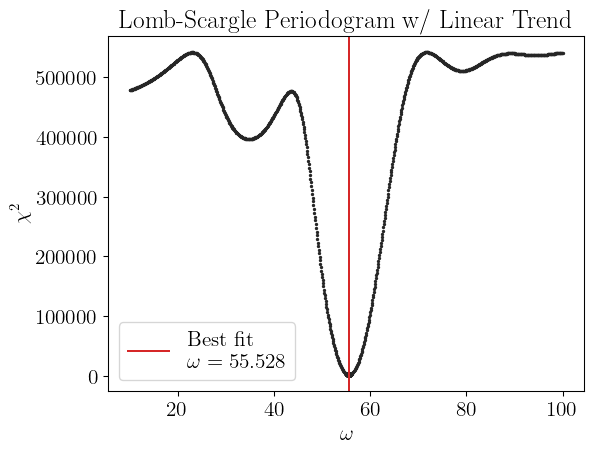

In [15]:
# Redo the plot, including a vertical red line for the minimum frequency we found
fig, ax = plt.subplots()
ax.scatter(omegas, chi2)
ax.scatter(omegas_fine, chi2_fine, color="custom:primary")

yl = ax.get_ylim()
ax.vlines(omega_best, *yl, "tab:red", label=f"Best fit\n$\omega = {omega_best:.3f}$")
ax.set_ylim(yl)

ax.set_title("Lomb-Scargle Periodogram w/ Linear Trend")
ax.set_xlabel("$\omega$")
ax.set_ylabel("$\chi^2$")

ax.legend()

plt.savefig("periodogram-close.png")
plt.savefig("periodogram-close.svg")

plt.show()

In [16]:
# The parameter array for the chosen best frequency
beta, _ = fit(omega_best)
omega_best, beta

(55.527527527527525,
 array([-2.31999580e+02,  6.51678906e+01,  6.23271375e+02,  4.18209515e+05]))

In [17]:
# Get the first two parameters in terms of an amplitude and phase of
# a single sinusoid using harmonic addition

amplitude = np.sqrt(beta[0]**2 + beta[1]**2)
phase = np.arctan(-beta[0]/beta[1]) / omega_best

amplitude, phase

(240.97854526214354, 0.023356999119047317)

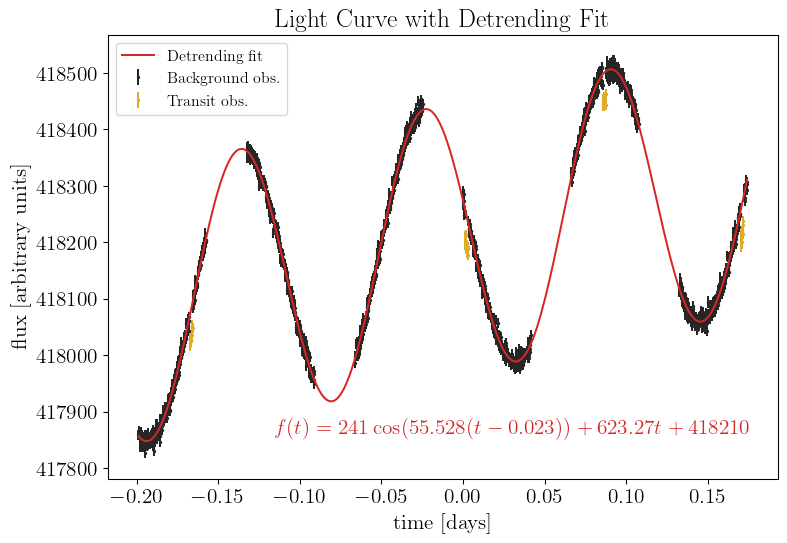

In [30]:
# Make a plot of our detrending model, including the full equation as text
fig, ax = plt.subplots(figsize=(9, 6))

ax.errorbar(df_clean["ptime"], df_clean["flux"], fmt="o", yerr=df_clean["err_flux"], label="Background obs.")
ax.errorbar(df_transit_clean["ptime"], df_transit_clean["flux"], color="custom:secondary", fmt="o", yerr=df_transit_clean["err_flux"], label="Transit obs.")

# Plot the model on a clean linspace array, so that it doesn't represent as a straight
# line in the observation gaps
t_plot = np.linspace(df_clean["ptime"].min(), df_clean["ptime"].max(), 300)
ax.text(0.25, 0.10, rf"$f(t) = {round(amplitude)} \cos({omega_best:.3f}(t-{phase:.3f})) + {beta[2]:.2f} t + {round(beta[3])}$", color="tab:red", transform=ax.transAxes)

ax.plot(t_plot, model(t_plot, omega_best, beta), zorder=99, label="Detrending fit", color="tab:red")
ax.legend(fontsize=12)

ax.set_ylabel("flux [arbitrary units]")
ax.set_xlabel("time [days]")

ax.set_title("Light Curve with Detrending Fit")

plt.savefig("fit-all.png")
plt.savefig("fit-all.pdf")

plt.show()

In [19]:
# Make a binned RMS residuals vs bin size plot

# First calculate the residuals
residuals = df_clean["flux"] - model(df_clean["ptime"], omega_best, beta)

# Repeat the observation window finding code from above, since the indices for the
# df_clean dataframe are different
obs_start_clean = (0, *(1 + np.where(np.diff(df_clean["ptime"]) > 0.01)[0]), len(df))
obs_windows_clean = list(zip(obs_start_clean[:-1], obs_start_clean[1:]))

bin_sizes = np.arange(1, 60)
rms = np.full_like(bin_sizes, np.nan, dtype=np.float64)
for i, bin_size in enumerate(bin_sizes):
    # Bins the residuals array and calculates the means for each bin
    # Prevents any bins from spanning a long gap in observations to
    # avoid edge effects
    means = [
        np.mean(residuals[j:j+bin_size])
        for k, l in obs_windows_clean
        for j in range(k, (l-k)-((l-k) % bin_size), bin_size)
    ]
    # Calculates the RMS given the means
    rms[i] = np.sqrt(np.sum(np.power(means, 2.)) / len(means))

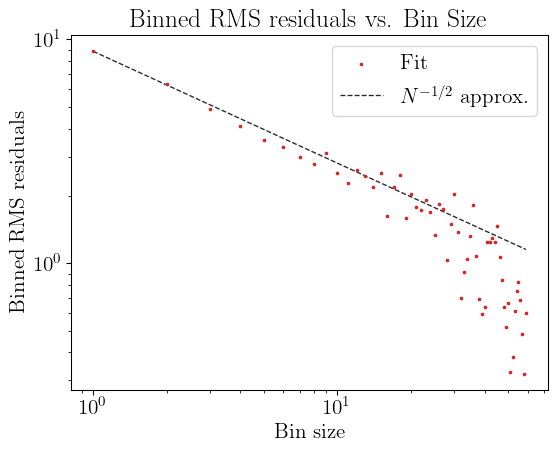

In [20]:
# Makes the RMS vs bin size plot, plotting the expected N^(-1/2) trend
fig, ax = plt.subplots()

ax.scatter(bin_sizes, rms, s=3, color="custom:highlight", label="Fit")

# We anchor the N^(-1/2) at our first point
ax.plot(
    bin_sizes, rms[0]/np.sqrt(bin_sizes), "--",
    color="custom:primary", lw=1, label="$N^{-1/2}$ approx.", zorder=-1
)

# Should appear as a line with slope -1/2 in log-log scaling
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Bin size")
ax.set_ylabel("Binned RMS residuals")

ax.legend()
ax.set_title("Binned RMS residuals vs. Bin Size")

plt.savefig("rms-bin-size.svg")
plt.savefig("rms-bin-size.png")

plt.show()

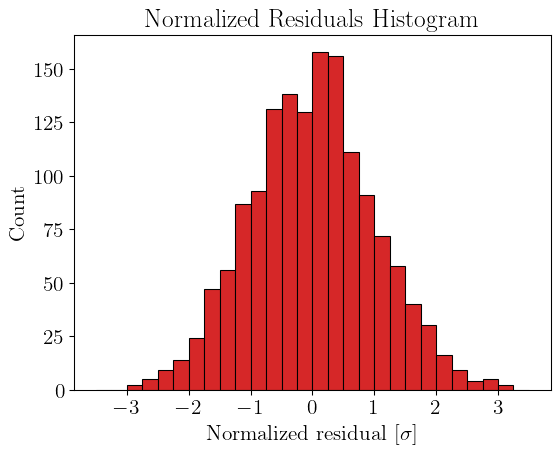

In [21]:
# Makes the of the normalized (divided by sigma) residuals. Should appear as a bell curve
# from approximately -3 to 3, since we filtered out the points 3 sigma or more away from the
# medians, which should approximate the model fit.
fig, ax = plt.subplots()

ax.hist(residuals / df_clean["err_flux"], color="tab:red", edgecolor="black", lw=0.8, bins=np.arange(-3.5, 3.6, 0.25))

# By default there aren't x-ticks at 1 and 3 sigma. Add them back in
ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])

ax.set_xlabel("Normalized residual [$\sigma$]")
ax.set_ylabel("Count")

ax.set_title("Normalized Residuals Histogram")

plt.savefig("normalized-residual.png")
plt.savefig("normalized-residual.svg")

plt.show()

In [22]:
# From the following plot, it doesn't appear as if the artificial data we're working with
# includes the transit edges (slope when the planet only partially overlaps the star), and
# it doesn't seem like there's limb-darkening applied.
# Our best estimate for the transit depth is just the mean of the transit fluxes after
# dividing out the model fit for the background flux.
transit_est = 1-np.mean(df_transit_clean["flux"]/model(df_transit_clean["ptime"], omega_best, beta))
print("Transit depth estimate:", transit_est)

Transit depth estimate: 0.00012063687154861835


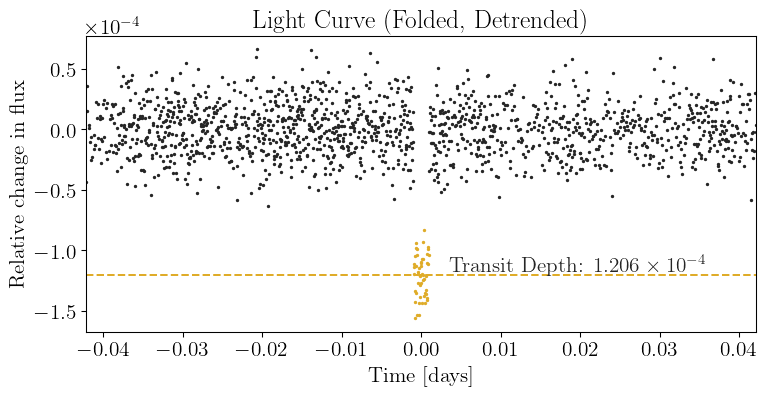

In [23]:
from matplotlib.transforms import offset_copy

fig, ax = plt.subplots(figsize=(9, 4))

# Scatter using the folded time we calculated earlier. This overlays each period of the planet's orbit
# on top of each other
ax.scatter(df_clean["ftime"], df_clean["flux"]/model(df_clean["ptime"], omega_best, beta)-1)
ax.scatter(df_transit_clean["ftime"], df_transit_clean["flux"]/model(df_transit_clean["ptime"], omega_best, beta)-1, color="custom:secondary")

ax.set_ylabel("Relative change in flux")

# The slide was short on horizontal space, so we removed the whitespace on either side of the data
xl = (np.min(df_clean["ftime"]), np.max(df_clean["ftime"]))
ax.set_xlim(xl)

# Plot the transit depth we estimated above as a dashed line spanning the entire graph
ax.hlines(-transit_est, *xl, color="custom:secondary", linestyle="--")

# Puts the text on top of the line we plotted with some padding in points rather than
# data units through the use of offset_copy
ax.text(0.0035, -transit_est,
        f"Transit Depth: ${transit_est*1e4:.3f} \\times 10^{{-4}}$",
        color="custom:primary",
        transform=offset_copy(ax.transData, fig=fig, x=0.0, y=3.0, units="points"))

# We represent the transit depth 0.00012... in scientific notation. Force the y-axis tick
# labels to display anything less than 10^-3 in scientific notation.
ax.ticklabel_format(axis="y", scilimits=(-3, 3))

ax.set_title("Light Curve (Folded, Detrended)")
ax.set_xlabel("Time [days]")

plt.savefig("light-curve.png")
plt.savefig("light-curve.pdf")

plt.show()

In [24]:
# The above method doesn't get any measure for the uncertainty of the fit,
# and we don't know a way to propogate the uncertainty from the fit into the
# depth measurement. Solution: MCMC everything, including the five parameters
# in the detrending fit as well as the transit depth


# Albert's MCMC code from Lab 2
try:
    import numba
    import functools

    nogiljit = functools.partial(numba.jit, nogil=True, nopython=True)
    prange = numba.prange
except ImportError:
    import warnings

    warnings.warn(
        "Numba not installed. Code will run many times slower. It is "
        "recommmended you install it using `pip install numba` or "
        "`conda install numba`."
    )
    nogiljit = lambda x: x
    prange = range

def log_likelihood_chi2_noise(model, x, y, sigma_y, **kwargs):
    """Factory for the generic the chi^2 likelihood function

    Returns a Numba jit'd function taking some input parameters and evaluates
    log(P(theta | D)) the log likelihood of the parameters theta based on the
    observed data (x, y, sigma_y). Output is improper.

    Assumes that the theta vector contains as its last element an extra noise
    (intrinsic) scatter term that should not be passed to the model. The
    noise term is added to the _squared uncertainty_ of the data (sigma_y^2).
 
    Args:
        model (factory_function): A factory function that takes in the array x
        and returns a function that models y at each x based on the parameters
        theta.
        x (array_like): Observation data x.
        y (array_like): Observation data y (is compared with model). Has the
        same dimensions as x.
        sigma_y (array_like): Uncertainty of observations. Has the same
        dimensions as x.
    """

    _model = model(x, y, sigma_y, **kwargs)

    sigma_y2 = sigma_y**2

    @nogiljit
    def _log_likelihood_chi2_noise(theta):
        SpV = sigma_y2 + np.exp(theta[-1])
        return -0.5*np.sum(
            np.log(SpV) +  (y - _model(theta[:-1]))**2 / SpV
        )

    return _log_likelihood_chi2_noise

def log_likelihood_chi2(model, x, y, sigma_y):
    """Factory for the generic chi^2 likelihood function

    Returns a Numba jit'd function taking some input parameters and evaluates
    log(P(theta | D)) the log likelihood of the parameters theta based on the
    observed data (x, y, sigma_y). Output is improper.

    Args:
        model (factory_function): A factory function that takes in the array x
        and returns a function that models y at each x based on the parameters
        theta.
        x (array_like): Observation data x.
        y (array_like): Observation data y (is compared with model). Has the
        same dimensions as x.
        sigma_y (array_like): Uncertainty of observations. Has the same
        dimensions as x.
    """    

    _model = model(x, y, sigma_y)

    # this factor is constant in the denominator
    two_sigma_y2 = 2*(sigma_y**2)

    @nogiljit
    def _log_likelihood_chi2(theta):
        return -np.sum((y - _model(theta))**2 / two_sigma_y2)

    return _log_likelihood_chi2

def log_mul2(fn1, fn2):
    """Take the product of two functions turning log probabilities.

    Assumes the input functions are wrapped with @numba.jit.

    Useful for creating a probability function from a likelihood and prior.
    """

    @nogiljit
    def _log_mul2(theta):
        return fn1(theta) + fn2(theta)
    return _log_mul2

def walker(log_probability_fn):
    """Returns a function that performs a MCMC walk from a specified
    (log) probability function, initial theta, and step_size.

    The function expects you to "bring your own array" to store the
    parameter and likelihood samples, allowing to treat each row of
    a higher dimensional array as a separate chain.

    The initial state should be specified as the beginning element in
    the theta array before passing it into the walk function, e.g.,
        theta[0, :] = initial_state

    The theta array should have shape (steps, number of parameters)
    and the optional log_probability save should have shape (steps,)

    To avoid serious memory fragmentation issues, you should ensure
    the supplied arrays are "C-contiguous". This should be the case
    by default with numpy if the "steps" dimension is the second to
    last index and the "parameter" dimension is the last index and
    no transposition or reordering is applied.

        See numpy documentation for more information on memory contiguity:
        https://numpy.org/doc/stable/dev/internals.html#

    Currently only supports Gaussian proposals. step_size is interpreted
    as the standard deviation of the sampled normal distribution for each
    parameter.

    This factory function is separate from walk_all to take advantage
    of numba compilation caching between separate runs.

    Args:
        log_probability_fn (function):
            a numba jit function accepting a single parameter theta and
            returning the log probability.        
    """    
    @nogiljit
    def _walk(state, steps, step_scale, last_log_probability, log_probability_save=None):
        for i in range(1, steps):
            # Generate a new proposal using a Gaussian for each parameter
            for j, s in enumerate(step_scale):
                state[i, j] = state[i-1, j] + np.random.normal(0, s)

            log_probability_proposal = log_probability_fn(state[i])
            
            # Metropolis method. This is the calculation to _reject_
            # the proposal, since we've already written the proposal to the
            # array
            #
            # If the new probability is greater than the old one, accept,
            # otherwise accept with P(accept) = P(theta_proposal)/P(theta)
            lp_diff = log_probability_proposal - last_log_probability

            if lp_diff > 0.0 or np.log(np.random.rand()) < lp_diff:
                # Proposal accepted, update last_log_probability
                last_log_probability = log_probability_proposal
            else:
                # Proposal rejected, copy previous state
                state[i, :] = state[i-1]

            if log_probability_save is not None:
                log_probability_save[i] = last_log_probability

        # return the last theta and probability for continuation
        return state[i], last_log_probability
    return _walk

@nogiljit
def numba_seed(a):
    """Seed the random generator state specifically for numba njit

    Numba requires the random generator seed for each thread running under njit
    to also be set in a njit function.
    """
    np.random.seed(a)

@nogiljit
def walk_all(walker, initial_guess, step_scale, seed, steps):
    """Run one or more MCMC walkers from specified initial guesses
    and random seeds.

    Results are completely stored in memory, limiting the max number of
    walkers/steps. See walk_all_zarr for a scaled up implementation allowing
    very large sample sizes using disk-based storage.

    The total number of bytes generated is equal to
        (# of walkers) * (# of steps) * (# of parameters + 1)
          * (4 bytes for float32, 8 bytes for float64)

    Parallelizes with numba prange (threads) when available, with one thread
    per walker.

    Args:
        walker (function):
            Walker function created with walker().
        initial_guess (array_like):
            Initial guess(es) for theta.
            If a 2-D array, should have shape (# of walkers, # of parameters)
            If a 1-D array, should have shape (# of parameters,)
        step_scale (array_like):
            Step scale. See documentation of walker() for interpretation.
            Should have the same size as the last index of initial_guesss
        seed (array_like of ints):
            Random seed for each walker. Should have the same sizeas the last
            index of initial_guesss
        steps (int):
            Number of steps for each walker
    Returns:
        theta_all (array_like):
            Array containing the posterior sample from MCMC. Is three
            dimensional with dimensions (walkers, steps, parameter)
            regardless of initial_guess shape due to numba limitations.
    """
    initial_guess = np.asarray(initial_guess)
    if len(initial_guess.shape) == 1:
        initial_guess = initial_guess.reshape((1, -1))
    elif len(initial_guess.shape) != 2:
        raise ValueError("initial_guess must have 1 or 2 dimensions.")

    Nwalkers, shapeN = initial_guess.shape

    # Use the dtype provided, allowing any size float to be used for
    # space/performance reasons.
    _dtype = initial_guess.dtype

    theta_all = np.full((Nwalkers, steps, shapeN), np.nan, dtype=_dtype)

    # Initialize each walker with the provided initial guess. This is the way
    # the walker function expects the initial guess.
    theta_all[:, 0, :] = initial_guess
 
    # numba.prange takes care of parallelization for us. This will run each walker
    # in a separate thread, setting the random seed appropriately. In the absence
    # of numba, runs a simple single-threaded loop without parallelization.
    for w in prange(Nwalkers):
        numba_seed(seed[w])
        walker(
            theta_all[w],
            steps,
            np.asarray(step_scale, dtype=_dtype),
            # Required to get inf in the correct dtype without numba
            # complaining about type mismatch
            np.array(-np.inf, dtype=_dtype)[()]
        )

    return theta_all

In [25]:
# This model fits the background data using the first five parameters in theta
def trended_sinusoid_model(x, *args):
    @nogiljit
    def _trended_sinusoid_model(theta):
        omega, A, B, C, D, depth = theta
        return A * np.sin(omega * x) + B * np.cos(omega * x) + C * x + D
    return _trended_sinusoid_model

# This model fits the transit data using the depth
# We scale the depth by 10000 so that it's around 1 (for better float precision)
def trended_sinusoid_model_transit(x, *args):
    @nogiljit
    def _trended_sinusoid_model(theta):
        omega, A, B, C, D, scaled_depth = theta
        return (1-scaled_depth/1e4) * (A * np.sin(omega * x) + B * np.cos(omega * x) + C * x + D)
    return _trended_sinusoid_model

# Since the result of each chi^2 likelihood function is a sum in log space, combining the chi^2 from the two
# fits is the same as multiplying them in linear space IF we relatively weight _each observation_ the same
# if we care more about fitting the transit well versus fitting the background perfectly, maybe weights
# could be applied
walker_6D = walker(log_mul2(
    log_likelihood_chi2(
        trended_sinusoid_model,
        np.array(df_clean["ptime"]),
        np.array(df_clean["flux"]),
        np.array(df_clean["err_flux"])
    ),
    log_likelihood_chi2(
        trended_sinusoid_model_transit,
        np.array(df_transit_clean["ptime"]),
        np.array(df_transit_clean["flux"]),
        np.array(df_transit_clean["err_flux"])
    ),
))

In [26]:
Nwalkers = 6

# Setting the random seed should produce reproducible results
np.random.seed(238195)

# Set some reasonable step scales
step_scale = np.array((0.01, 1, 1, 2, 1, 0.01))

# Seed the walkers with the best parameters we already know
initial_guesses = np.array([(omega_best, *beta, transit_est*1e4)] * Nwalkers)

# Generate the per-thread random seeds for the walker code
seed = np.random.randint(np.iinfo(int).max, size=(Nwalkers,))

steps = 1024 * 64

# Do the MCMC!
theta_6D = walk_all(walker_6D, initial_guesses, step_scale, seed, steps=steps)

KeyboardInterrupt: 

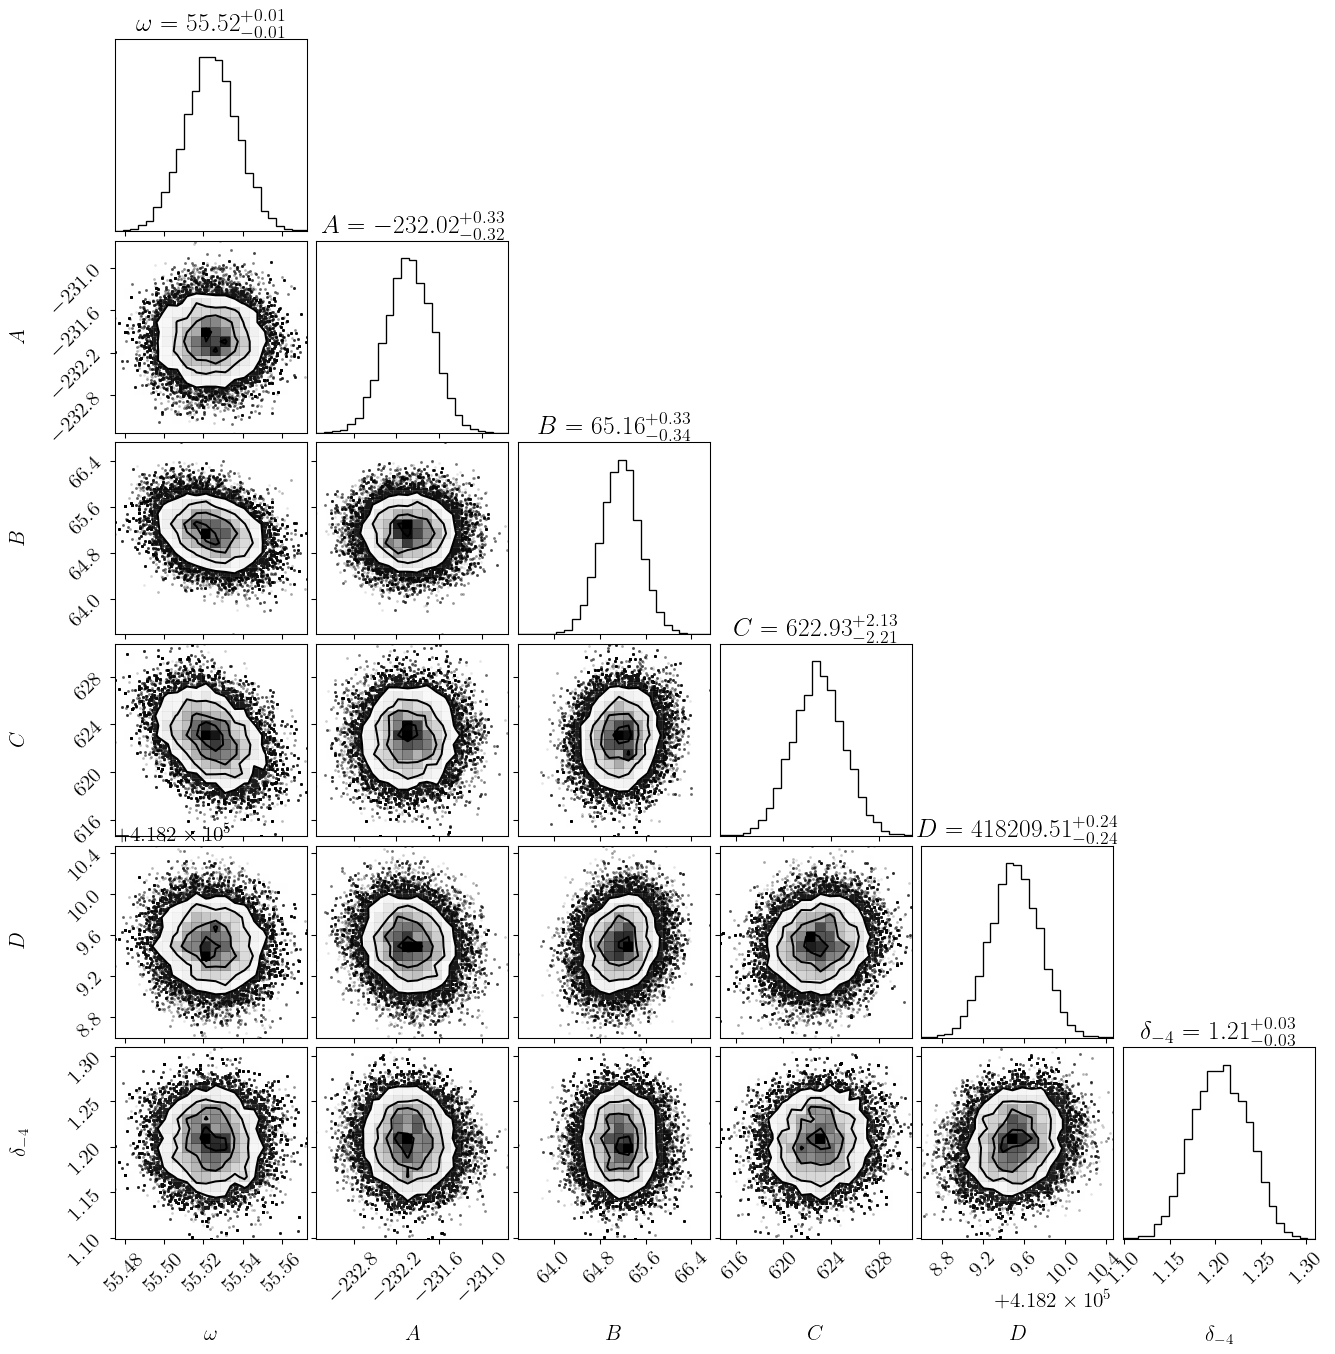

In [27]:
import corner

corner.corner(
    theta_6D[:, 16000:, :].reshape(-1, 6),
    bins=20, hist_bin_factor=1.25,
    show_titles=True, labels=[r"$\omega$", "$A$", "$B$", "$C$", "$D$", "$\delta_{-4}$"],
    labelpad=0.15
)

plt.savefig("corner.svg")
plt.savefig("corner.png")

plt.show()

In [ ]:
# Get just the 1-D histogram of transit depth, since that's all we have space on the slides for
import math

fig = plt.figure(figsize=(6, 6))

corner.corner(
    theta_6D[:, 16000:, -1].ravel(),
    # the same bins as before, account for hist_factor
    bins=25, show_titles=True,
    labels=["Transit Depth"],
    labelpad=-0.15,
    title_fmt=".3f", fig=fig,
    # Quantiles code from last class
    quantiles=((1-math.erf(1/math.sqrt(2)))/2, 0.5, (1+math.erf(1/math.sqrt(2)))/2)
)

ax = fig.gca()
t = ax.get_title()

# Remember that our MCMC fit the depth times 10000!!
ax.set_title(t + r" $\times 10^{-4}$")
ax.set_xlabel("Transit Depth $\\times 10^4$")

plt.savefig("transit_depth_hist.png")
plt.savefig("transit_depth_hist.svg")

plt.show()